# Human Activity Recognition Using Deep Convolutional Network + LSTM

In this tutorial, we will build a convolutional network + LSTM to do human activity recognition using the smart phone sensor data from the [WISDM](http://dl.acm.org/citation.cfm?doid=1964897.1964918) lab.

## Prerequisite

### Define paths

We will define the project path so it will be easy to refer to files we need for building models. 

In [1]:
PRJ_DIR = "/home/har/har-tutorial"

### Import modules

First, we need to load the conda environment so we can use the user-specificlibraries. The only way I know how to do this within the jupyter notebook is by inserting the environment paths in `sys.path`

In [2]:
import os
import sys

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

We will use the [Keras](http://keras.io) library to build the deep learning model. It is a very straightforward wrapper around the popular tensor-based library [Theano](http://deeplearning.net/software/theano/introduction.html) and Google's [TensorFlow](https://www.tensorflow.org/). The user just need to connect the layers, the library will build the low-level parameters and operations by calling the backend libraries. Eventually the model is translated into C++ code for speed.

### Use Theano backend.

If you are running these stuff for the first time, you should also execute the following command to setup the keras configuration. It by default uses Tensorflow backend, but the virtualenv does not have Tensorflow installed. We will use Theano backend.

In [4]:
import keras
from keras.models import Sequential
from keras.layers import (
    Activation, BatchNormalization, Dense, Dropout, Flatten,
    Conv2D, MaxPooling2D, LSTM, Permute, Reshape
)
from keras.optimizers import RMSprop
from keras.regularizers import l1_l2
from keras.utils import np_utils

Now, `deepsense` is a python library for processing HAR datasets. It also includes some scripts to train models. We will use the classes in the library to manipulate the [WISDM dataset](http://www.cis.fordham.edu/wisdm/dataset.php#actitracker).

## Read data set

Most time we are spending when building a machine learning model is in two things:

  1. Cleaning and consolidating data set
  2. Tuning parameters
  
I have previously re-formatting the WISDM data set into training-ready format. Everything is wrapped within a [`pickle`](https://docs.python.org/2/library/pickle.html) file. 

In [20]:
X, y, meta, ACTIVITY_MAPPING = pickle.load(
    open(os.path.join(PRJ_DIR, "data/wisdm_subset.pkl"), "rb")
)

The pickle file contains following information:

#### Data matrices: `X` and `y`

The transformed `numpy.ndarray` that can directly fed to the model

  * `X` : the sensor data of size (`num_samples`, `window_size`, `num_channels`)
  * `y` : the array of labeled activities for each window of size (`num_samples`)

To transform the data from what you see in `wisdm.df` to `wisdm.X`, we first applied a resampling and denoising filter of frequency 20 Hz to the data, and then we applied a moving window of 4 seconds, with stride length 1 second to the signal. Therefore, the dimension of the training set is:

  * `window_size = 80` (4 seconds * 20 Hz)
  * `num_channels = 3` 

Another important aspect in the matrix transformation is that for convergence purpose, we transformed the input values to [-1, 1]. To do that, we divided the original acceleration measurement $(m/s^2)$ by $3g$, and capped off values that's $>1$ or $<-1$.

In [21]:
print("Shape of X: {}".format(X.shape))
print("Shape of y: {}".format(y.shape))

Shape of X: (1200, 80, 3)
Shape of y: (1200,)


#### Meta data: `meta`

A data frame that connects the matrices back to the annotation, including the randomly split training and test set label (20% of test).

In [22]:
meta.sample(10)

,activity,begin,subject_id,r_std,set
817,Jogging,2008-01-10 21:28:30.200,646,3.677376,train
1093,Standing,2013-08-22 20:17:52.250,1775,0.018878,test
1041,Walking,2008-01-10 21:31:12.150,726,2.413375,test
241,Standing,2013-01-06 06:56:42.850,1246,0.008883,train
673,Walking,2011-10-24 18:13:07.750,635,1.946268,train
941,Walking,2011-10-13 18:08:50.450,655,1.255016,train
216,Sitting,2013-07-12 13:40:40.150,1603,0.015777,train
778,Standing,2013-06-04 17:40:35.550,194,0.020224,train
952,Walking,2013-09-17 17:30:08.050,1104,2.072712,train
1051,Walking,2013-01-07 19:08:25.850,1274,0.015441,test


#### Activity map: `ACTIVITY_MAPPING`

The mapping between the code in `y` and the actual activity name.

In [23]:
ACTIVITY_MAPPING

{'Jogging': 5,
 'LyingDown': 3,
 'Sitting': 1,
 'Stairs': 2,
 'Standing': 0,
 'Walking': 4}

### Splitting the data set

We now split the data set into training and testing based on the index in the metadata. The testing set will not be used in learning weights in the network in any way. We will only use it to evaluate if our model is overfitting and select a stopping point for training.

Note that we convert the matrix to float 32 for the benefit of running it on GPU.

In [24]:
y

array([4, 5, 1, ..., 0, 4, 5])

In [25]:
train_idx = meta[meta["set"] == "train"].index.values
test_idx = meta[meta["set"] == "test"].index.values

X_train = X[train_idx].astype(np.float32)
y_train = y[train_idx].astype(np.float32)
X_test = X[test_idx]
y_test = y[test_idx]

Given that `y` is categorical, we also have to convert the vector of activity code into a matrix using one-hot encoding

In [26]:
nb_classes = len(ACTIVITY_MAPPING) # number of activities 

Y_train = np_utils.to_categorical(y_train, nb_classes).astype(np.float32)
Y_test = np_utils.to_categorical(y_test, nb_classes).astype(np.float32)

## Build a model

Now let's build a deep learning model!

### Set model parameters

Let's first define some parameters

In [56]:
batch_size = 16
nb_epoch = 10 # only train for 10 iteration
num_channels = 3 # x, y, z
sliding_window_length = 80 # 4-second window * 20 Hz sampling rate

num_conv_filters = 32 # number of convolutional filters
conv_filter_size = 3 # size of the convolutional filters
num_lstm_units = 64 # number of LSTM units

The `Sequential` model is the simplest way to connect layers: one after another. We will use it to build our network. Our goal is to build something like this:

![](../figures/cnn_annot.png)

This structure idea was taken from [this paper](https://www.ncbi.nlm.nih.gov/pubmed/26797612) (original source code [here](https://github.com/sussexwearlab/DeepConvLSTM), but it uses another wrapper library called [Lasagne](https://github.com/Lasagne/Lasagne)), where they use Conv + LSTM for gesture and locomotion recognition based on sensor data from various location in human body. Here I simplified it and added a few other layers to speed up the training.

In [51]:
model = Sequential()

# 4 layers of conv
model.add(Conv2D(filters=num_conv_filters, kernel_size=(conv_filter_size, 1),
                input_shape=(sliding_window_length, num_channels, 1)))
model.add(BatchNormalization(axis=3))
model.add(Activation("relu"))

model.add(Conv2D(filters=num_conv_filters, kernel_size=(conv_filter_size, 1)))
model.add(BatchNormalization(axis=3))
model.add(Activation("relu"))

model.add(MaxPooling2D(pool_size=(2, 1)))

model.add(Conv2D(filters=2*num_conv_filters, kernel_size=(conv_filter_size, 1)))
model.add(BatchNormalization(axis=3))
model.add(Activation("relu"))

model.add(Conv2D(filters=2*num_conv_filters, kernel_size=(conv_filter_size, 1)))
model.add(BatchNormalization(axis=3))
model.add(Activation("relu"))

model.add(MaxPooling2D(pool_size=(2, 1)))

model.add(Reshape((model.output_shape[1],
                   model.output_shape[2] * model.output_shape[3])))

# 2 layers of lstm
model.add(Dropout(0.5))
model.add(LSTM(num_lstm_units, return_sequences=True))

model.add(Dropout(0.5))
model.add(LSTM(num_lstm_units))
model.add(Dense(nb_classes,
                kernel_regularizer=l1_l2(l1=1e-2, l2=1e-2),
                activation="softmax"))

You can access the number of parameters and the shape of output in each layer by the `.summary()` function.

In [52]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 78, 3, 32)         128       
_________________________________________________________________
batch_normalization_34 (Batc (None, 78, 3, 32)         128       
_________________________________________________________________
activation_34 (Activation)   (None, 78, 3, 32)         0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 76, 3, 32)         3104      
_________________________________________________________________
batch_normalization_35 (Batc (None, 76, 3, 32)         128       
_________________________________________________________________
activation_35 (Activation)   (None, 76, 3, 32)         0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 38, 3, 32)         0         
__________

### Convolutional layers

The convolutional layer has a sparse connection to the adjecent units:

![](http://deeplearning.net/tutorial/_images/conv_1D_nn.png)

In the figure above, lines with same color correspond to the same weight. 

For activation, the convolution layers use Rectified Linear Unit (ReLU), which is shown to have [better convergence](http://www.cs.toronto.edu/~fritz/absps/imagenet.pdf) than `tanh` function.

![](http://cs231n.github.io/assets/nn1/relu.jpeg)

You can see the first convolutional layer contains 

$$ 32 \text{ feature maps (or convolutional units)} \times 3 \text{ (convolutional filter size)} + 32 \text{ bias} = 128 \text{ parameters}$$

Similarly, the second layer contains 

$$ 32 \times 32 \times 3 + 32 = 3104 \text{ parameters} $$

### Batch normalization layer

According to [this paper](https://arxiv.org/pdf/1502.03167v3.pdf) from Google, a batch normalization layer can reduce internal covariate shift between layers and thus reduce the convergence time and might eliminatethe need for Dropout. Each unit in batch normailzation calculates the mean and standard deviation in the mini batch and shift the input by

$$ y = \gamma x + \beta$$

Therefore, the unmber of parameter is $2 \times 32 = 64$ in the first BatchNormalization layer.

### Max pooling layer

A max pooling layer parttions input into non-overlapping rectangles and output the maximum in each subregion. It reduces the data size and thus speed up the computation. Usually the pooling size is 2, too much pooling may result in loss of too much information. 

### LSTM layer

Long short-term memory (LSTM) layer is one of the most widely used recurrent neural network (RNN) layer. The units in the recurrent neural network forms directed cycles which allow them to exhibit temporal behavior. Therefore we often see the application of RNNs in sequential data such as [handwriting recognition](https://arxiv.org/pdf/1312.4569.pdf), [speech recognition](https://www.microsoft.com/en-us/research/publication/lstm-time-and-frequency-recurrence-for-automatic-speech-recognition/), or [sentimental analysis](http://deeplearning.net/tutorial/lstm.html).

A LSTM unit is different from other RNN unit in the sense that it has a forget gate:

![](http://deeplearning.net/tutorial/_images/lstm_memorycell.png)

For each of the unit at time $t$, it involves the following calculation:

  * Input gate 
      $$i_t = \sigma(W_ix_t + U_i h_{t-1} + b_i)$$
  
  * Candidate value for the state of memory cell 
      $$\tilde{C}_t = tanh(W_cx_t + U_ch_{t-1} + b_c)$$
  
  * Activation of forget cell
      $$f_t = \sigma(W_fx_t + U_fh_{t-1} + b_f)$$
  
  * The state of memory cell 
      $$C_t = i_t \tilde{C}_t + f_t C_{t-1}$$
  
  * Output gate
      $$o_t = \sigma(W_ox_t + U_o h_{t-1} + b_o)$$
  
  * Output 
      $$h_t = o_t tanh(C_t)$$

The above calculations involve the following parameters:
  * $W$ : weight vector of `input_size`
  * $U$ : weight vector of `output_size`
  * $b$ : a scalar of bias

Therefore, for instance, the first LSTM layer involves

$(64 + 192 + 1) \times 64 \text{ units} \times 4 (\text{input gate, candidate state, forget, output gate}) = 65792$ parameters,

and the second LSTM layer involves 

$(64 + 64 + 1) \times 64 \times 4 = 33024$ parameters

### Dropout layer

Large number of parameters tends to overfit the training data, the number of parameters in deep neural network is gigantic. One simple technique that is offen used to prevent overfitting is to insert a [dropout](http://www.cs.toronto.edu/~rsalakhu/papers/srivastava14a.pdf) layer in between fully connected layers (_e.g._ LSTM). A dropout layer randomly set a fraction `p` of input units to 0 at each update during training time: 

![](../figures/dropout.png)

## Configure model for training

With the model structure in place, we will configure the training methods for the model.

In [53]:
rmsprop = RMSprop()
model.compile(loss="categorical_crossentropy",
              optimizer=rmsprop,
              metrics=["accuracy"])

### Choose optimizer

Optimizers are basically a gradient descent algorithm used for optimizing the weights during each update. Here we will use the `RMSProp` optimizer as it is suggested to be [a good choice for recurrent neural networks](https://keras.io/optimizers/#rmsprop). A list of other optimizers and their formulation can be found in [this](http://sebastianruder.com/optimizing-gradient-descent/index.html)  great blog post. 

### `compile`

Although the name might be misleading, this function does not really start compiling the model into C++ code, instead just setting more training behavior. Here we use the categorical [crossentropy](https://en.wikipedia.org/wiki/Cross_entropy) as the target value to optimize. In each iteration (or as the deep learning guys like to call it, the `epoch`) we will also output the prediction accuracy as output. 

## Finally ... we start training

... but before that, since we are using a 2-D convolutional network here, we will have to reshape our input into `(num_samples, 1, sliding_window_length, num_channels)` to conform with the input shape of our network.

In [54]:
X_train = X_train.reshape(-1, sliding_window_length, num_channels, 1)
X_test = X_test.reshape(-1, sliding_window_length, num_channels, 1)

And for time's sake. Let's just train on a subset of samples: 20,000 training, and 1,000 testing

And now we can train

In [57]:
history = model.fit(X_train, Y_train,
                    batch_size=batch_size,
                    epochs=nb_epoch,
                    validation_data=(X_test, Y_test),
                    shuffle=True)


Train on 1000 samples, validate on 200 samples
Epoch 1/10
1000/1000 [==============================] - 8s - loss: 0.9488 - acc: 0.7830 - val_loss: 3.5989 - val_acc: 0.1450
Epoch 2/10
1000/1000 [==============================] - 7s - loss: 0.9003 - acc: 0.7950 - val_loss: 3.3000 - val_acc: 0.1450
Epoch 3/10
1000/1000 [==============================] - 7s - loss: 0.8083 - acc: 0.8110 - val_loss: 3.1368 - val_acc: 0.1450
Epoch 4/10
1000/1000 [==============================] - 9s - loss: 0.7708 - acc: 0.8030 - val_loss: 2.1967 - val_acc: 0.2650
Epoch 5/10
1000/1000 [==============================] - 8s - loss: 0.7113 - acc: 0.8190 - val_loss: 1.7404 - val_acc: 0.4900
Epoch 6/10
1000/1000 [==============================] - 7s - loss: 0.6885 - acc: 0.8170 - val_loss: 1.6718 - val_acc: 0.5150
Epoch 7/10
1000/1000 [==============================] - 7s - loss: 0.6830 - acc: 0.8240 - val_loss: 1.1067 - val_acc: 0.6700
Epoch 8/10
1000/1000 [==============================] - 7s - loss: 0.6594 - ac

You can see the validation loss was originally very high. At some point it starts to drop significantly, which is a characteristic when you use BatchNormalization layer (based on my personal experience). At 10th epoch, you already get around 80% validation accuracy.

We can make predictions for new data by doing:

In [58]:
Y_test_pred = model.predict(X_test)

y_test_pred = np.apply_along_axis(lambda r: np.argmax(r), 1, Y_test_pred)

# calculate the accuracy of the prediction
np.mean(y_test_pred == y_test)

0.73499999999999999

We can plot the validation loss progression from the output from the `fit` function.

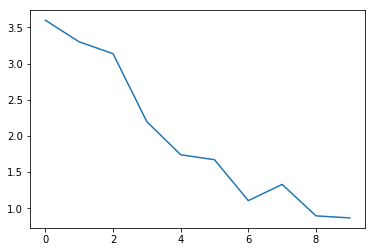

In [59]:
fig, ax = plt.subplots()
ax.plot(history.history["val_loss"])

## More

For other techniques for training model you may go through the following links:

* Callback functions: [`ModelCheckpoint`](https://keras.io/callbacks/#modelcheckpoint), [`ReduceLROnPlateau`](https://keras.io/callbacks/#reducelronplateau), and [`EarlyStopping`](https://keras.io/callbacks/#earlystopping) are quite useful
* Hyperparameter search using `sklearn`'s [`GridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV) function. An example can be found in `kera`'s [example script](https://github.com/fchollet/keras/blob/master/examples/mnist_sklearn_wrapper.py).
* Parallelization: [`mxnet`](https://github.com/dmlc/mxnet) or [Spark](https://databricks.com/blog/2016/01/25/deep-learning-with-apache-spark-and-tensorflow.html)
* An nice overview on available deep learning library out there (more focused on python): [My Top 9 Favorite Python Deep Learning Libraries](http://www.pyimagesearch.com/2016/06/27/my-top-9-favorite-python-deep-learning-libraries/)